# SHAP Analysis

In [ ]:
import pandas as pd
import lightgbm as lgb
import shap
from scipy.stats import spearmanr, pearsonr
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [15]:
# from pathlib import Path
import os
from pathlib import Path
filepath = Path(os.path.abspath(''))
print(filepath)

/nfs/ml_lab/projects/improve/data/experiments/cross-dataset-drp-paper


In [16]:
outdir = filepath / 'results_for_paper_revision'
os.makedirs(outdir, exist_ok=True)

comment_outdir = outdir / 'reviewer1_comment5'
comment_outdir.mkdir(parents=True, exist_ok=True)

## Two pairs (both exhibit good generalization)
### 1. ctrp (trained on split 0) --> ctrp (tested on split 0)
### 2. ctrp (trained on split 0) --> ccle (tested on entire dataset)

In [17]:
# Settings (fixed)
model_name = 'LGBM'
train_dataset = 'CTRPv2'

,source,improve_sample_id,improve_chem_id,auc,ic50,ec50,ec50se,r2fit,einf,hs,...,mordred.SRW10,mordred.TSRW10,mordred.MW,mordred.AMW,mordred.WPath,mordred.WPol,mordred.Zagreb1,mordred.Zagreb2,mordred.mZagreb1,mordred.mZagreb2
0,CTRPv2,ACH-000623,Drug_82,0.9082,NaN,6.217,0.1809,0.8536,0.7515,2.5650,...,-0.247245,-0.272318,-0.511817,0.065019,-0.069495,-0.447454,-0.441843,-0.428379,-0.544237,-0.447231
1,CTRPv2,ACH-000075,Drug_573,0.7649,5.998,6.713,0.1077,0.8897,0.4799,1.9540,...,0.596236,0.198897,-0.049142,-0.164354,-0.069495,0.043120,0.060048,0.080778,0.118505,-0.125764
2,CTRPv2,ACH-000780,Drug_970,0.9188,4.125,4.125,1.5800,0.8186,0.0000,0.7146,...,-0.462950,-0.424790,-0.628087,-0.044288,-0.069495,-0.550732,-0.597602,-0.587965,-0.472803,-0.566485


(28666, 2584)
(28666, 2571)


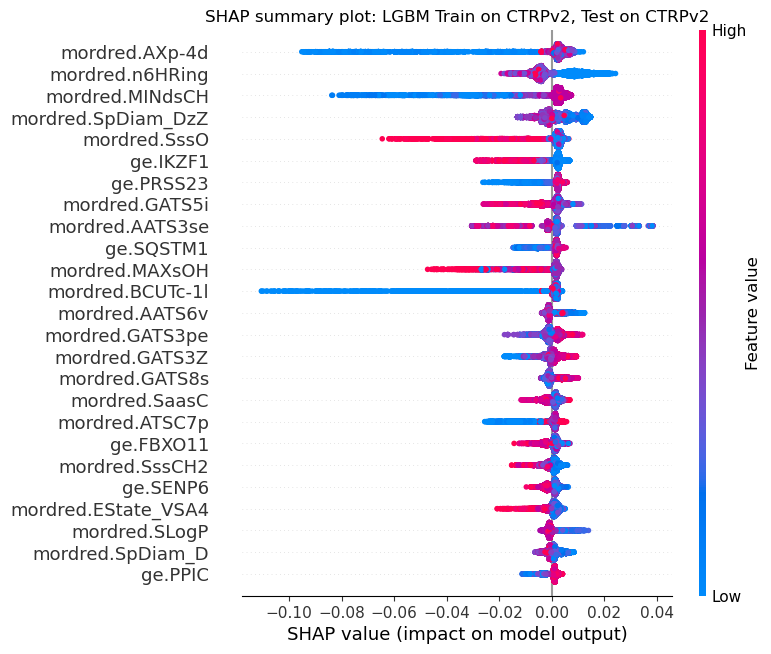

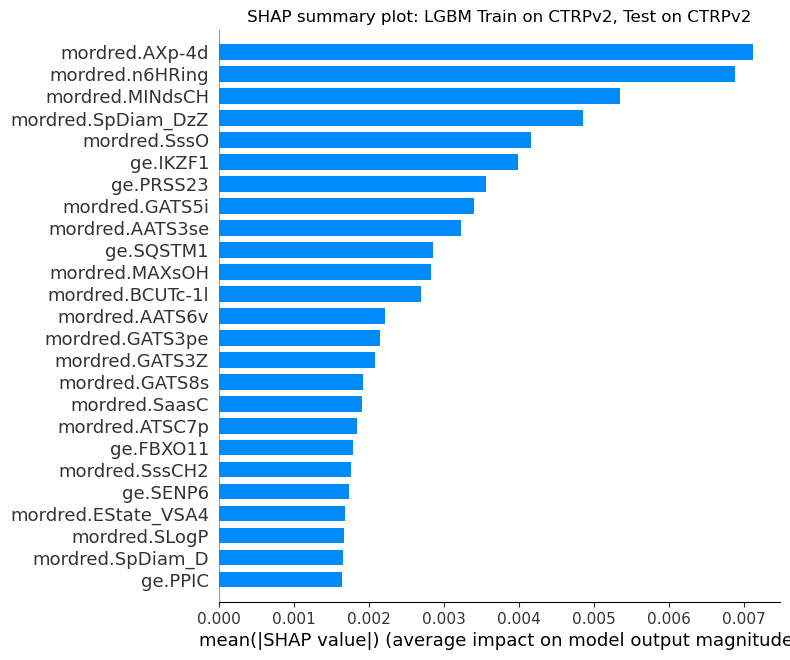

,feature,mean_abs_shap
0,mordred.AXp-4d,0.007130
1,mordred.n6HRing,0.006886
2,mordred.MINdsCH,0.005348
3,mordred.SpDiam_DzZ,0.004854
4,mordred.SssO,0.004161
5,ge.IKZF1,0.003984
6,ge.PRSS23,0.003566
7,mordred.GATS5i,0.003398
8,mordred.AATS3se,0.003234
9,ge.SQSTM1,0.002860


In [18]:
# Load test data (CTRPv2 --> CTRPv2)
test_dataset = 'CTRPv2'

# Load test data (CTRPv2)
ctrp_ctrp_test_data = pd.read_parquet(f'/nfs/ml_lab/projects/improve/data/experiments/run/v1.1/lgbm/improve_output/preprocess/{train_dataset}-{test_dataset}/split_0/test_data.parquet')
display(ctrp_ctrp_test_data.iloc[:3])

# Extract features for CTRPv2 test data (CTRPv2 --> CTRPv2)
df = ctrp_ctrp_test_data.copy()
fea_list = ["ge", "mordred"]
fea = [c for c in df.columns if (c.split('.')[0]) in fea_list]
X_test_ctrp = df[fea]
print(ctrp_ctrp_test_data.shape)
print(X_test_ctrp.shape)

# Load trained model (LGBM, CTRPv2, split 0)
modelpath = f'/nfs/ml_lab/projects/improve/data/experiments/run/v1.1/lgbm/improve_output/train/{train_dataset}/split_0/model.txt'
lgbm_ctrp = lgb.Booster(model_file=str(modelpath))
lgbm_ctrp.params = {'objective': 'regression'}

# SHAP explainers
lgbm_explainer = shap.TreeExplainer(lgbm_ctrp)
shap_values_lgbm_ctrp = lgbm_explainer.shap_values(X_test_ctrp)

max_disp = 25

# SHAP Summary Plot (global importance + distribution)
shap.summary_plot(shap_values_lgbm_ctrp, X_test_ctrp, max_display=max_disp, show=False, plot_size=0.2)
plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}.png', bbox_inches='tight')
plt.show()

# SHAP Bar Plot (mean importance only)
shap.summary_plot(shap_values_lgbm_ctrp, X_test_ctrp, plot_type="bar", max_display=max_disp, show=False, plot_size=0.2)
plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}_barplot.png', bbox_inches='tight')
plt.show()

shap_df = pd.DataFrame(shap_values_lgbm_ctrp, columns=X_test_ctrp.columns)
mean_abs_shap = shap_df.abs().mean() # Compute mean absolute SHAP value for each feature
top = mean_abs_shap.sort_values(ascending=False).head(max_disp).reset_index() # Convert to DataFrame and sort
top.columns = ["feature", "mean_abs_shap"]
top.to_csv(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}_top{max_disp}.csv', index=False)
display(top)

del test_dataset, ctrp_ctrp_test_data, df, fea, lgbm_ctrp, lgbm_explainer, shap_values_lgbm_ctrp, X_test_ctrp

,source,improve_sample_id,improve_chem_id,auc,ic50,ec50,ec50se,r2fit,einf,hs,...,mordred.SRW10,mordred.TSRW10,mordred.MW,mordred.AMW,mordred.WPath,mordred.WPol,mordred.Zagreb1,mordred.Zagreb2,mordred.mZagreb1,mordred.mZagreb2
0,CCLE,ACH-000564,Drug_195,0.4798,7.381,7.445,0.0799,0.9784,0.094,1.400,...,0.887861,0.168529,-0.070211,0.081759,0.196298,0.223857,0.025434,0.133973,-0.107694,-0.169836
1,CCLE,ACH-000420,Drug_749,0.7952,5.223,5.223,0.8176,0.9461,0.000,1.414,...,0.562225,0.202441,-0.123617,-0.540742,-0.069495,-0.137618,0.060048,0.095976,-0.417244,-0.068730
2,CCLE,ACH-000523,Drug_1279,0.8950,NaN,6.451,0.8055,0.3837,0.743,4.000,...,-0.032610,0.154227,-0.078592,-1.133223,-0.069495,-0.111798,-0.061099,-0.071209,-0.189716,-0.006510


(9519, 2584)
(9519, 2571)


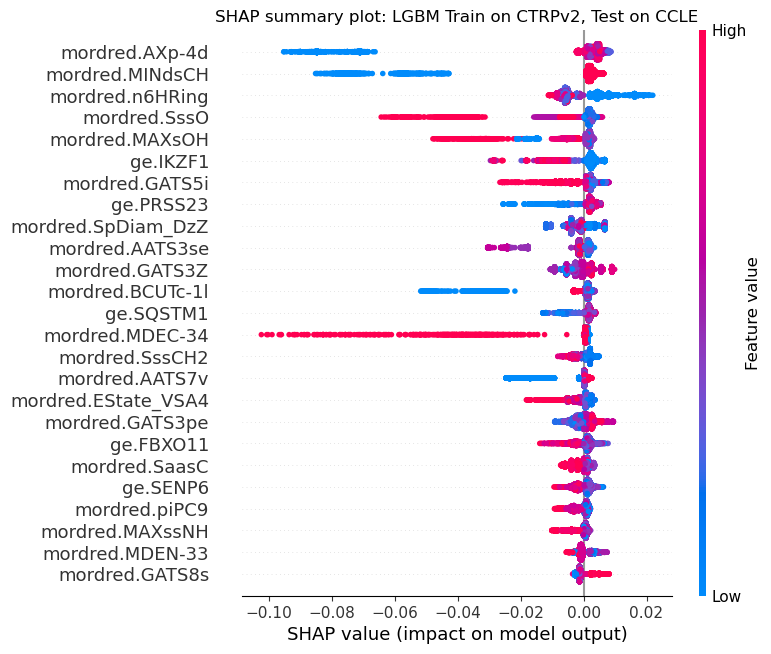

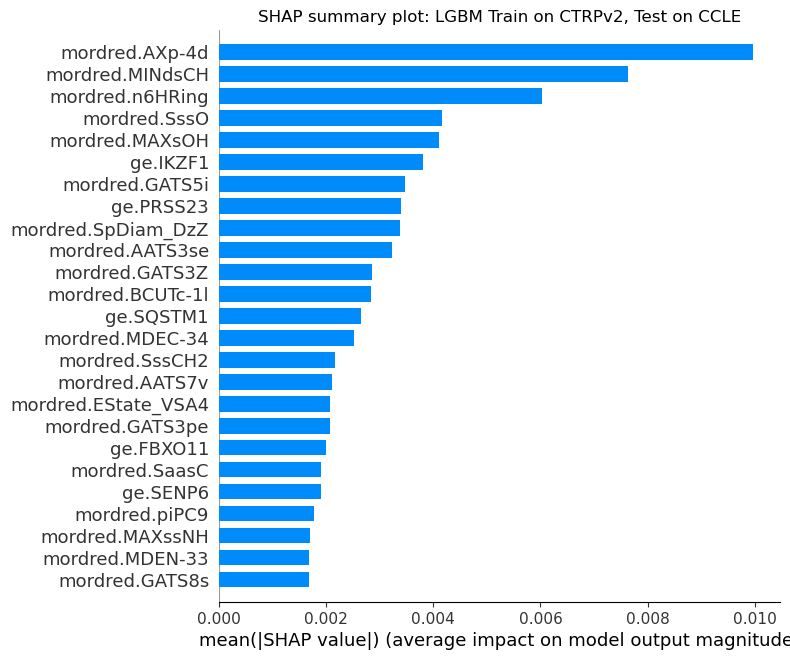

,feature,mean_abs_shap
0,mordred.AXp-4d,0.009971
1,mordred.MINdsCH,0.007631
2,mordred.n6HRing,0.006029
3,mordred.SssO,0.004167
4,mordred.MAXsOH,0.004110
5,ge.IKZF1,0.003817
6,mordred.GATS5i,0.003465
7,ge.PRSS23,0.003389
8,mordred.SpDiam_DzZ,0.003378
9,mordred.AATS3se,0.003226


In [19]:
# Load test data (CTRPv2 --> CCLE)
test_dataset = 'CCLE'

# Load test data (CCLE)
ctrp_ccle_test_data = pd.read_parquet(f'/nfs/ml_lab/projects/improve/data/experiments/run/v1.1/lgbm/improve_output/preprocess/{train_dataset}-{test_dataset}/split_0/test_data.parquet')
display(ctrp_ccle_test_data.iloc[:3])

# Extract features for CCLE test data (CTRPv2 --> CCLE)
df = ctrp_ccle_test_data.copy()
fea_list = ["ge", "mordred"]
fea = [c for c in df.columns if (c.split('.')[0]) in fea_list]
ccle_fea = df[fea]
X_test_ccle = df[fea]
print(ctrp_ccle_test_data.shape)
print(X_test_ccle.shape)

# Load trained model (LGBM, CCLE, split 0)
modelpath = f'/nfs/ml_lab/projects/improve/data/experiments/run/v1.1/lgbm/improve_output/train/{train_dataset}/split_0/model.txt'
lgbm_ctrp = lgb.Booster(model_file=str(modelpath))
lgbm_ctrp.params = {'objective': 'regression'}

# SHAP explainers
lgbm_explainer = shap.TreeExplainer(lgbm_ctrp)
shap_values_lgbm_ccle = lgbm_explainer.shap_values(X_test_ccle)

max_disp = 25

# SHAP Summary Plot (global importance + distribution)
shap.summary_plot(shap_values_lgbm_ccle, X_test_ccle, max_display=max_disp, show=False, plot_size=0.2)
plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}.png', bbox_inches='tight')
plt.show()

# SHAP Bar Plot (mean importance only)
shap.summary_plot(shap_values_lgbm_ccle, X_test_ccle, plot_type="bar", max_display=max_disp, show=False, plot_size=0.2)
plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}_barplot.png', bbox_inches='tight')
plt.show()

shap_df = pd.DataFrame(shap_values_lgbm_ccle, columns=X_test_ccle.columns)
mean_abs_shap = shap_df.abs().mean() # Compute mean absolute SHAP value for each feature
top = mean_abs_shap.sort_values(ascending=False).head(max_disp).reset_index() # Convert to DataFrame and sort
top.columns = ["feature", "mean_abs_shap"]
top.to_csv(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}_top{max_disp}.csv', index=False)
display(top)

del test_dataset, ctrp_ccle_test_data, df, fea, X_test_ccle, lgbm_ctrp, lgbm_explainer, shap_values_lgbm_ccle

## Two pairs (one good and one bad generalization)
### 1. CTRP --> gCSI
### 2. CCLE --> gCSI

In [20]:
# Settings (fixed)
model_name = 'LGBM'
test_dataset = 'gCSI'

,source,improve_sample_id,improve_chem_id,auc,ic50,ec50,ec50se,r2fit,einf,hs,...,mordred.SRW10,mordred.TSRW10,mordred.MW,mordred.AMW,mordred.WPath,mordred.WPol,mordred.Zagreb1,mordred.Zagreb2,mordred.mZagreb1,mordred.mZagreb2
0,gCSI,ACH-000652,Drug_501,0.8722,NaN,7.088,0.2965,0.7012,0.7517,3.654,...,0.588593,0.335912,0.096901,0.147300,-0.069495,0.068940,0.181194,0.225165,-0.244614,-0.022065
1,gCSI,ACH-000222,Drug_501,0.8516,NaN,7.112,0.3192,0.6635,0.7139,1.859,...,0.588593,0.335912,0.096901,0.147300,-0.069495,0.068940,0.181194,0.225165,-0.244614,-0.022065
2,gCSI,ACH-000565,Drug_1105,0.9544,NaN,4.696,352.9000,0.0000,0.6087,2.428,...,2.209828,0.716077,0.974458,-0.431724,-0.069494,1.695578,1.288814,1.479058,1.152302,0.876229


(4941, 2584)
(4941, 2571)


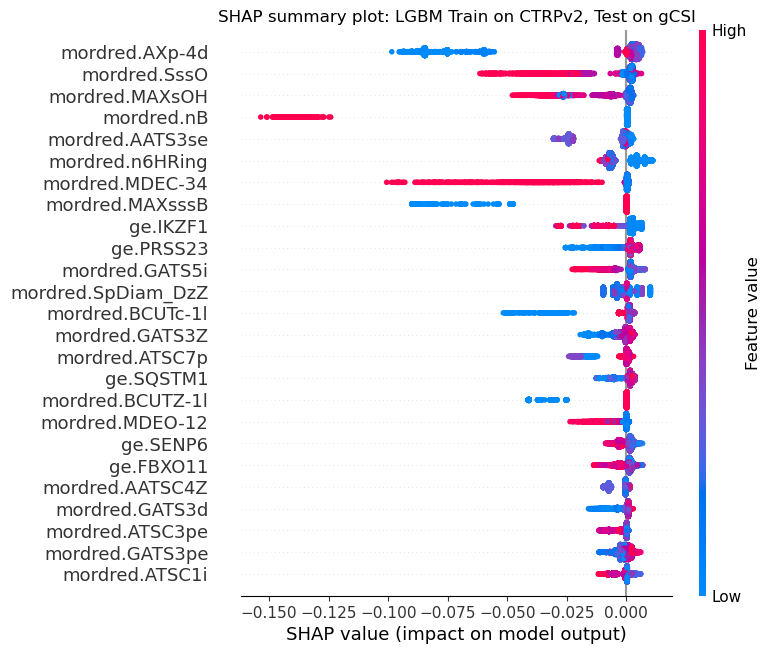

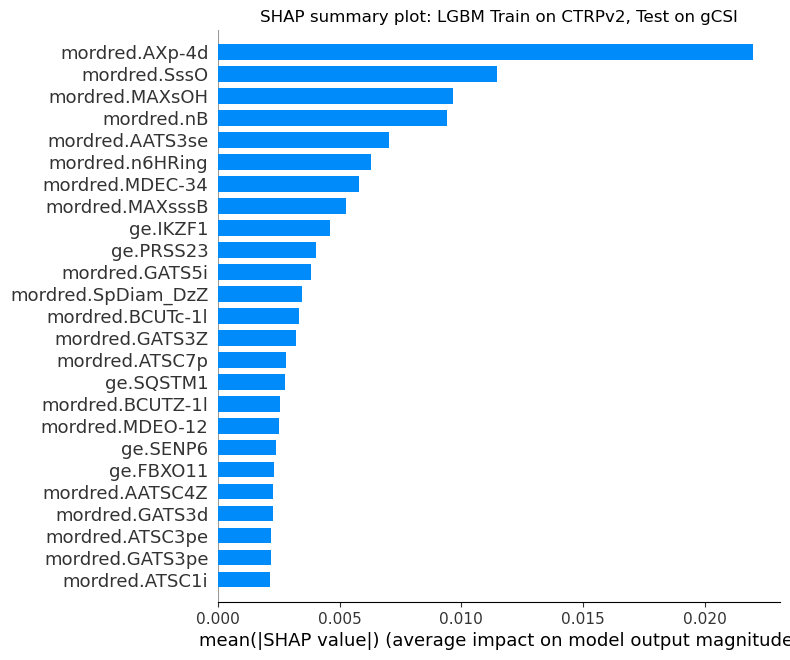

,feature,mean_abs_shap
0,mordred.AXp-4d,0.022002
1,mordred.SssO,0.011468
2,mordred.MAXsOH,0.009659
3,mordred.nB,0.009398
4,mordred.AATS3se,0.007036
5,mordred.n6HRing,0.006289
6,mordred.MDEC-34,0.005803
7,mordred.MAXsssB,0.005262
8,ge.IKZF1,0.004584
9,ge.PRSS23,0.004017


In [21]:
# Load test data (CTRPv2 --> CCLE)
train_dataset = 'CTRPv2'
ctrp_gcsi_test_data = pd.read_parquet(f'/nfs/ml_lab/projects/improve/data/experiments/run/v1.1/lgbm/improve_output/preprocess/{train_dataset}-{test_dataset}/split_0/test_data.parquet')
display(ctrp_gcsi_test_data.iloc[:3])

# Extract features for CTRPv2 test data (CTRPv2 --> gCSI)
df = ctrp_gcsi_test_data.copy()
fea_list = ["ge", "mordred"]
fea = [c for c in df.columns if (c.split('.')[0]) in fea_list]
X_ctrp_gcsi = df[fea]
print(ctrp_gcsi_test_data.shape)
print(X_ctrp_gcsi.shape)

# Load trained model (LGBM, CTRPv2, split 0)
modelpath = f'/nfs/ml_lab/projects/improve/data/experiments/run/v1.1/lgbm/improve_output/train/{train_dataset}/split_0/model.txt'
lgbm_ctrp = lgb.Booster(model_file=str(modelpath))
lgbm_ctrp.params = {'objective': 'regression'}

# SHAP explainers
lgbm_ctrp_explainer = shap.TreeExplainer(lgbm_ctrp)
shap_values_lgbm_ctrp = lgbm_ctrp_explainer.shap_values(X_ctrp_gcsi)

# Plot
# shap.summary_plot(shap_values_lgbm_ctrp, X_ctrp_gcsi, max_display=25, show=False, plot_size=0.2)
# plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
# plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}.png', bbox_inches='tight')

max_disp = 25

# SHAP Summary Plot (global importance + distribution)
shap.summary_plot(shap_values_lgbm_ctrp, X_ctrp_gcsi, max_display=max_disp, show=False, plot_size=0.2)
plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}.png', bbox_inches='tight')
plt.show()

# SHAP Bar Plot (mean importance only)
shap.summary_plot(shap_values_lgbm_ctrp, X_ctrp_gcsi, plot_type="bar", max_display=max_disp, show=False, plot_size=0.2)
plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}_barplot.png', bbox_inches='tight')
plt.show()

shap_df = pd.DataFrame(shap_values_lgbm_ctrp, columns=X_ctrp_gcsi.columns)
mean_abs_shap = shap_df.abs().mean() # Compute mean absolute SHAP value for each feature
top = mean_abs_shap.sort_values(ascending=False).head(max_disp).reset_index() # Convert to DataFrame and sort
top.columns = ["feature", "mean_abs_shap"]
top.to_csv(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}_top{max_disp}.csv', index=False)
display(top)

del train_dataset, ctrp_gcsi_test_data, df, fea, X_ctrp_gcsi, lgbm_ctrp, lgbm_ctrp_explainer, shap_values_lgbm_ctrp

,source,improve_sample_id,improve_chem_id,auc,ic50,ec50,ec50se,r2fit,einf,hs,...,mordred.SRW10,mordred.TSRW10,mordred.MW,mordred.AMW,mordred.WPath,mordred.WPol,mordred.Zagreb1,mordred.Zagreb2,mordred.mZagreb1,mordred.mZagreb2
0,gCSI,ACH-000781,Drug_1087,0.7853,4.331,6.446,0.2139,0.9728,0.4766,0.6289,...,-1.493409,-2.063575,-0.326512,2.738320,-0.301333,-1.050398,-1.334821,-1.332904,-0.400920,-1.100329
1,gCSI,ACH-000573,Drug_1105,0.5063,7.949,8.261,0.0256,0.9984,0.3046,1.3070,...,2.942593,1.533900,2.714212,-0.737632,-0.301319,3.266672,2.838252,2.943525,3.319222,2.469591
2,gCSI,ACH-000548,Drug_895,0.7111,5.954,6.074,0.0721,0.9864,0.1643,1.4440,...,1.566134,1.304929,0.648123,-0.763378,-0.301326,1.401271,1.152162,1.323160,0.246312,0.825288


(4941, 2584)
(4941, 2571)


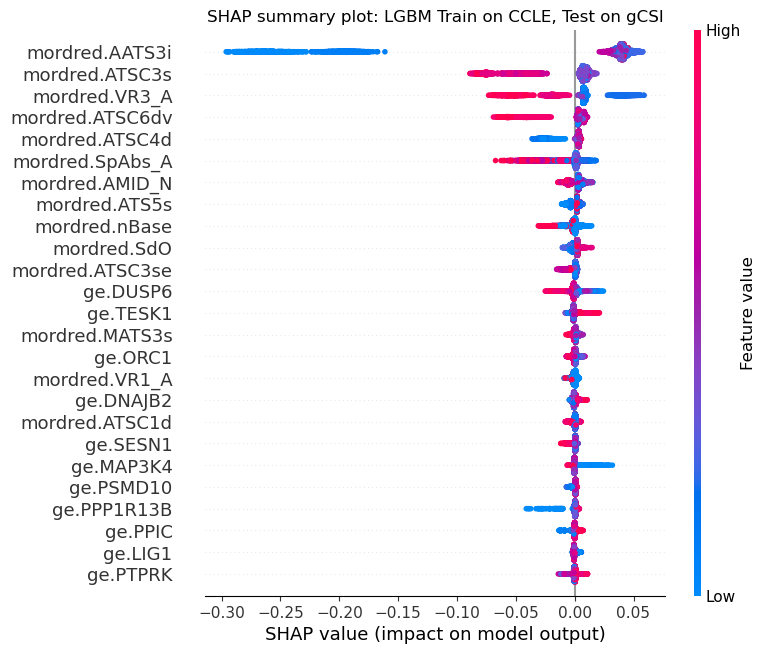

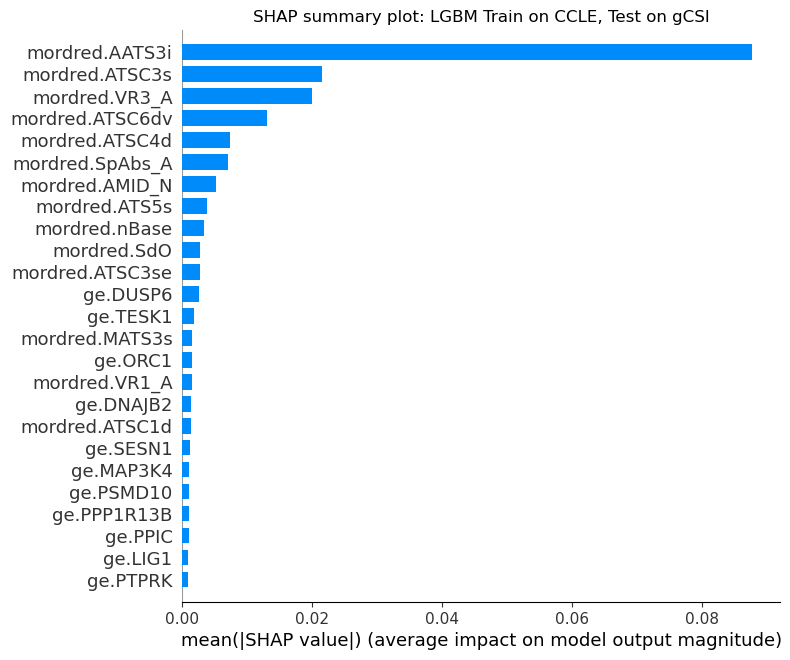

,feature,mean_abs_shap
0,mordred.AATS3i,0.087588
1,mordred.ATSC3s,0.021471
2,mordred.VR3_A,0.020008
3,mordred.ATSC6dv,0.013083
4,mordred.ATSC4d,0.007332
5,mordred.SpAbs_A,0.007091
6,mordred.AMID_N,0.005116
7,mordred.ATS5s,0.003747
8,mordred.nBase,0.003326
9,mordred.SdO,0.002783


In [22]:
# Load test data (CTRPv2 and CCLE)
train_dataset = 'CCLE'
ccle_gcsi_test_data = pd.read_parquet(f'/nfs/ml_lab/projects/improve/data/experiments/run/v1.1/lgbm/improve_output/preprocess/{train_dataset}-{test_dataset}/split_0/test_data.parquet')
display(ccle_gcsi_test_data.iloc[:3])

# Extract features for CCLE test data (CCLE --> gCSI)
df = ccle_gcsi_test_data.copy()
fea_list = ["ge", "mordred"]
fea = [c for c in df.columns if (c.split('.')[0]) in fea_list]
X_ccle_gcsi = df[fea]
print(ccle_gcsi_test_data.shape)
print(X_ccle_gcsi.shape)

# Load trained model (LGBM, CCLE, split 0)
modelpath = f'/nfs/ml_lab/projects/improve/data/experiments/run/v1.1/lgbm/improve_output/train/{train_dataset}/split_0/model.txt'
lgbm_ccle = lgb.Booster(model_file=str(modelpath))
lgbm_ccle.params = {'objective': 'regression'}

# SHAP explainers
lgbm_ccle_explainer = shap.TreeExplainer(lgbm_ccle)
shap_values_lgbm_gcsi = lgbm_ccle_explainer.shap_values(X_ccle_gcsi)

# # Plot
# shap.summary_plot(shap_values_lgbm_gcsi, X_ccle_gcsi, max_display=25, show=False, plot_size=0.2)
# plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
# plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}.png', bbox_inches='tight')

max_disp = 25

# SHAP Summary Plot (global importance + distribution)
shap.summary_plot(shap_values_lgbm_gcsi, X_ccle_gcsi, max_display=max_disp, show=False, plot_size=0.2)
plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}.png', bbox_inches='tight')
plt.show()

# SHAP Bar Plot (mean importance only)
shap.summary_plot(shap_values_lgbm_gcsi, X_ccle_gcsi, plot_type="bar", max_display=max_disp, show=False, plot_size=0.2)
plt.title(f'SHAP summary plot: {model_name} Train on {train_dataset}, Test on {test_dataset}')
plt.savefig(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}_barplot.png', bbox_inches='tight')
plt.show()

shap_df = pd.DataFrame(shap_values_lgbm_gcsi, columns=X_ccle_gcsi.columns)
mean_abs_shap = shap_df.abs().mean() # Compute mean absolute SHAP value for each feature
top = mean_abs_shap.sort_values(ascending=False).head(max_disp).reset_index() # Convert to DataFrame and sort
top.columns = ["feature", "mean_abs_shap"]
top.to_csv(comment_outdir / f'shap_lgbm_{train_dataset}_{test_dataset}_top{max_disp}.csv', index=False)
display(top)

del train_dataset, ccle_gcsi_test_data, df, fea, X_ccle_gcsi, lgbm_ccle, lgbm_ccle_explainer, shap_values_lgbm_gcsi